<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- 여러 알고리즘으로 만든 모델의 성능을 교차 검증을 통해 예측해 봅니다.
- 성능이 좋을 것으로 예상되는 알고리즘으로 최적화된 성능의 모델을 만듭니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [5]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [6]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1}) # light xgb는 문자열 target을 인식하지 못함 

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- **CHURN: 이탈(번호이동) 여부 - Target**

In [9]:
# 데이터 살펴보기
data.head()


,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


In [10]:
# 기술통계 확인
data.describe().T



,count,mean,std,min,25%,50%,75%,max
id,20000.0,10000.50000,5773.647028,1.0,5000.75,10000.5,15000.25,20000.0
COLLEGE,20000.0,0.50240,0.500007,0.0,0.00,1.0,1.00,1.0
INCOME,20000.0,80281.44775,41680.586319,20007.0,42217.00,75366.5,115881.75,159983.0
OVERAGE,20000.0,85.97955,85.992324,-2.0,0.00,59.0,179.00,335.0
LEFTOVER,20000.0,23.89865,26.816645,0.0,0.00,14.0,41.00,89.0
HOUSE,20000.0,493155.26425,252407.884692,150002.0,263714.25,452259.5,702378.00,999996.0
HANDSET_PRICE,20000.0,389.61510,213.820682,130.0,219.00,326.0,533.25,899.0
OVER_15MINS_CALLS_PER_MONTH,20000.0,8.00070,8.925418,0.0,1.00,4.0,15.00,29.0
AVERAGE_CALL_DURATION,20000.0,6.00225,4.402558,1.0,2.00,5.0,10.00,15.0
CHURN,20000.0,0.49260,0.499958,0.0,0.00,0.0,1.00,1.0


In [11]:
# 변수 관련 정보 확인
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           20000 non-null  int64 
 1   COLLEGE                      20000 non-null  int64 
 2   INCOME                       20000 non-null  int64 
 3   OVERAGE                      20000 non-null  int64 
 4   LEFTOVER                     20000 non-null  int64 
 5   HOUSE                        20000 non-null  int64 
 6   HANDSET_PRICE                20000 non-null  int64 
 7   OVER_15MINS_CALLS_PER_MONTH  20000 non-null  int64 
 8   AVERAGE_CALL_DURATION        20000 non-null  int64 
 9   REPORTED_SATISFACTION        20000 non-null  object
 10  REPORTED_USAGE_LEVEL         20000 non-null  object
 11  CONSIDERING_CHANGE_OF_PLAN   20000 non-null  object
 12  CHURN                        20000 non-null  int64 
dtypes: int64(10), object(3)
memory 

# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [14]:
# 변수 제거: id
data.drop(columns = 'id' ,inplace=True)

data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**2) x, y 분리**

In [16]:
# x, y 분리
target = "CHURN"

x = data.drop(columns = target)
y = data.loc[:,target]


**3) 가변수화**

In [18]:
# 가변수화
dummy_cols = ['REPORTED_SATISFACTION','CONSIDERING_CHANGE_OF_PLAN','REPORTED_USAGE_LEVEL']

x = pd.get_dummies(data=x , columns = dummy_cols , drop_first = True , dtype = int)

x

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,0,1,0,0,1,0,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,1,0,0,0,0,1,0,0
2,1,27273,230,0,305049,201,16,15,0,1,0,0,0,0,0,1,0,0,0,1
3,0,120070,38,33,788235,780,3,2,0,1,0,0,1,0,0,0,0,0,1,0
4,1,29215,208,85,224784,241,21,1,0,0,0,1,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,153252,0,23,368403,597,1,6,0,0,1,0,0,0,0,0,0,1,0,0
19996,1,107126,71,82,237397,609,5,2,0,0,1,0,0,0,1,0,0,0,0,1
19997,0,78529,0,66,172589,275,0,2,0,1,0,0,1,0,0,0,0,0,1,0
19998,0,78674,47,41,572406,288,4,2,0,0,0,1,1,0,0,0,0,1,0,0


**4) 학습용, 평가용 데이터 분리**

In [20]:
# 학습용, 평가용 데이터 분리
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x,y,random_state =1 , stratify=y)



**5) 정규화**

In [22]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_test)

# 4.성능 예측

- 여러 알고리즘으로 만든 모델의 성능을 교차 검증을 통해 예측해 봅니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 예측된 성능 정보를 수집해 마지막에 비교합니다.

In [24]:
# xgboost 설치
# !pip install xgboost

In [25]:
# lightgbm 설치
# !pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [27]:
# 불러오기(분류)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # 로지스틱 회귀는 분류 모형임 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 성능예측 (Cross val score)
from sklearn.model_selection import cross_val_score
# 모델 튜닝
from sklearn.model_selection import GridSearchCV # CV = cross value

result = {} # 성능 정보 수집용 


**1) KNN**

- KNN 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [109]:
# 성능예측
model = KNeighborsClassifier()

# 검증하기
cv_score = cross_val_score(model,x_train_s,y_train,cv=10)# 모델, 학습용 데이터 x y , 분할개수 cv
# 확인
print(cv_score) # 정확도 10개 : 분할학습 한결과 10개 
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.61733333 0.594      0.598      0.60266667 0.61933333 0.608
 0.60533333 0.58466667 0.592      0.61333333]
평균: 0.6034666666666666
표준편차: 0.010818913480053746


In [111]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()

**2) Decision Tree**

- Decision Tree 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [114]:
# 성능예측
model = DecisionTreeClassifier(max_depth=5,  random_state=1) # default = Accuracy

# 검증하기
cv_score = cross_val_score(model, x_train, y_train, cv=10)
# 확인
print(cv_score)
print('평균:', cv_score.mean()) # 정확도 
print('표준편차:', cv_score.std())


[0.72933333 0.70066667 0.698      0.68933333 0.69133333 0.67866667
 0.69       0.68333333 0.682      0.70866667]
평균: 0.6951333333333334
표준편차: 0.01431409561702495


In [116]:
# 결과수집
result['Decision Tree'] = cv_score.mean()

**3) Logistic Regression**

- Logistic Regression 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [119]:
# 성능예측
# 선언하기
model = LogisticRegression()

# 검증하기
cv_score = cross_val_score(model, x_train , y_train , cv = 10 )

# 확인
print(cv_score) # 정확도 10개 : 분할학습 한결과 10개 
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.65       0.632      0.62466667 0.65733333 0.63333333 0.62733333
 0.614      0.62333333 0.61533333 0.65866667]
평균: 0.6336
표준편차: 0.015509710220088293


In [120]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()

**4) Random Forest**

- Random Forest 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [122]:
# 성능예측
model = RandomForestClassifier(max_depth = 5)

# 검증하기
cv_score = cross_val_score(model, x_train , y_train , cv = 10 )

# 확인
print(cv_score) # 정확도 10개 : 분할학습 한결과 10개 
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())


[0.72066667 0.684      0.68133333 0.7        0.696      0.67666667
 0.68266667 0.69466667 0.68333333 0.718     ]
평균: 0.6937333333333333
표준편차: 0.014594367254374387


In [123]:
# 결과수집
result['Random Forest'] = cv_score.mean()

**5) XGBoost**

- XGBoost 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [127]:
# 성능예측
model = XGBClassifier(max_depth =5)

# 검증하기
cv_score = cross_val_score(model, x_train , y_train , cv = 10 )

# 확인
print(cv_score) # 정확도 10개 : 분할학습 한결과 10개 
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.70733333 0.69533333 0.67933333 0.68733333 0.696      0.68666667
 0.67866667 0.67933333 0.678      0.68733333]
평균: 0.6875333333333333
표준편차: 0.009107018050809925


In [128]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 모델의 성능을 교차 검증을 통해 예측해 봅니다.

In [130]:
# 성능예측
model = LGBMClassifier(max_depth = 5,verbose = -1, importance_type = 'gain') 

# 검증하기
cv_score = cross_val_score(model, x_train , y_train , cv = 10 )

# 확인
print(cv_score) # 정확도 10개 : 분할학습 한결과 10개 
print('평균:', cv_score.mean())
print('표준편차:', cv_score.std())

[0.72866667 0.70066667 0.69266667 0.68733333 0.694      0.69333333
 0.69333333 0.69       0.682      0.71      ]
평균: 0.6972
표준편차: 0.01267648742094328


In [131]:
# 결과수집
result['LightGBM'] = cv_score.mean()

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [133]:
# 성능 비교
print(result)


{'KNN': 0.6034666666666666, 'Decision Tree': 0.6951333333333334, 'Logistic Regression': 0.6336, 'Random Forest': 0.6937333333333333, 'XGBoost': 0.6875333333333333, 'LightGBM': 0.6972}


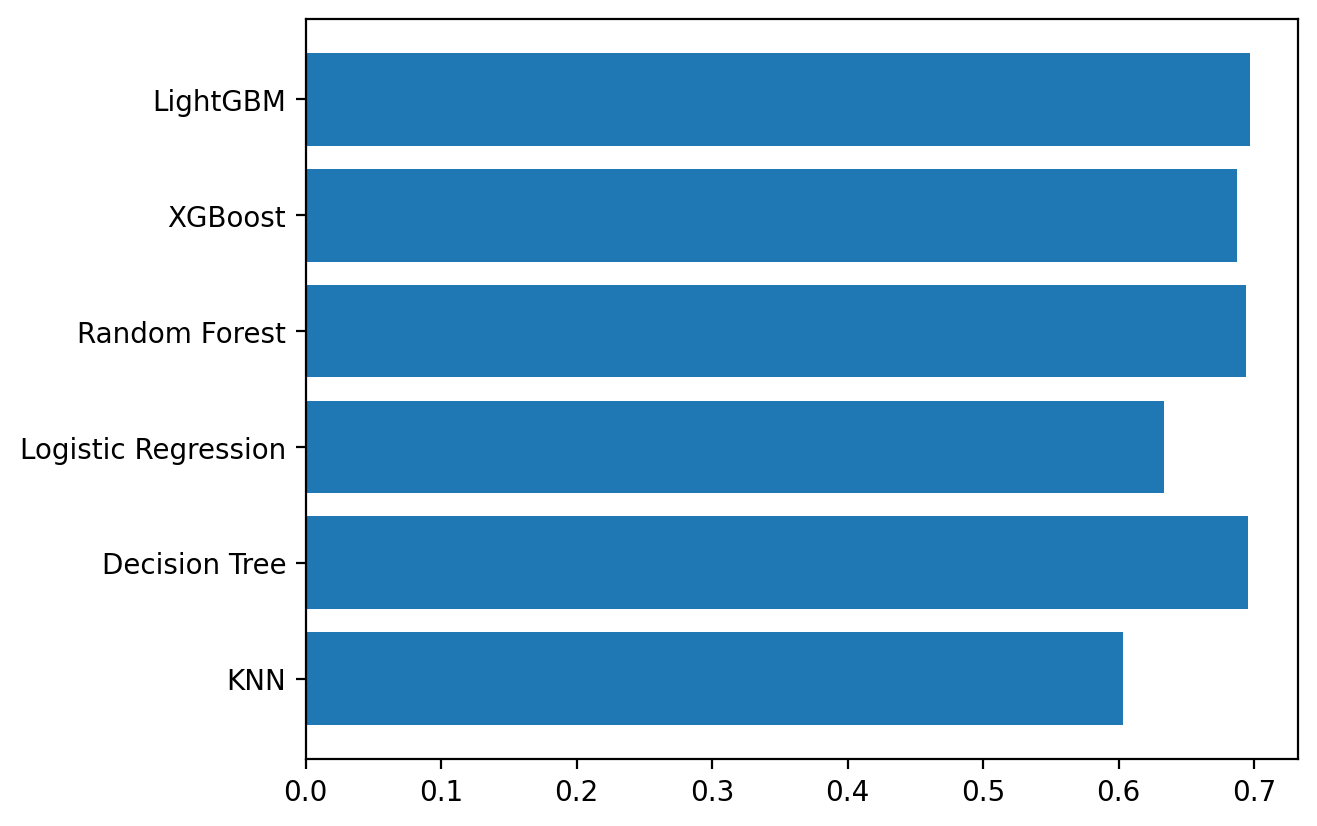

In [141]:
# 성능 시각화 비교

# result 성능 비교 
plt.barh(y= result.keys() ,width=result.values())
plt.show()

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 알고리즘으로 모델링합니다.
- 본 실습에서는 하이퍼파라미터가 최적화된 LightGBM 모델을 만듭니다.

In [97]:
# 파라미터
param = {'max_depth': range(1, 21),
         'n_estimators': range(60, 131, 10)}




In [99]:
# 학습하기(많은 시간이 소요될 수 있음)
model_grid = GridSearchCV(LGBMClassifier(verbose=-1), param ,cv= 5 , scoring ='accuracy')
model_grid.fit(x_train, y_train)



GridSearchCV(estimator=LGBMClassifier(verbose=-1),
             param_grid={'max_depth': range(1, 21),
                         'n_estimators': range(60, 131, 10)})

In [101]:
# 1. 최적 파라미터 출력
best_params = model_grid.best_params_ # 최적 파라미터 
print("Best Parameters:", best_params)

# 2. 최고 예측 성능 출력
best_score = model_grid.best_score_
print("Best Score:", best_score)

Best Parameters: {'max_depth': 3, 'n_estimators': 70}
Best Score: 0.7012666666666666


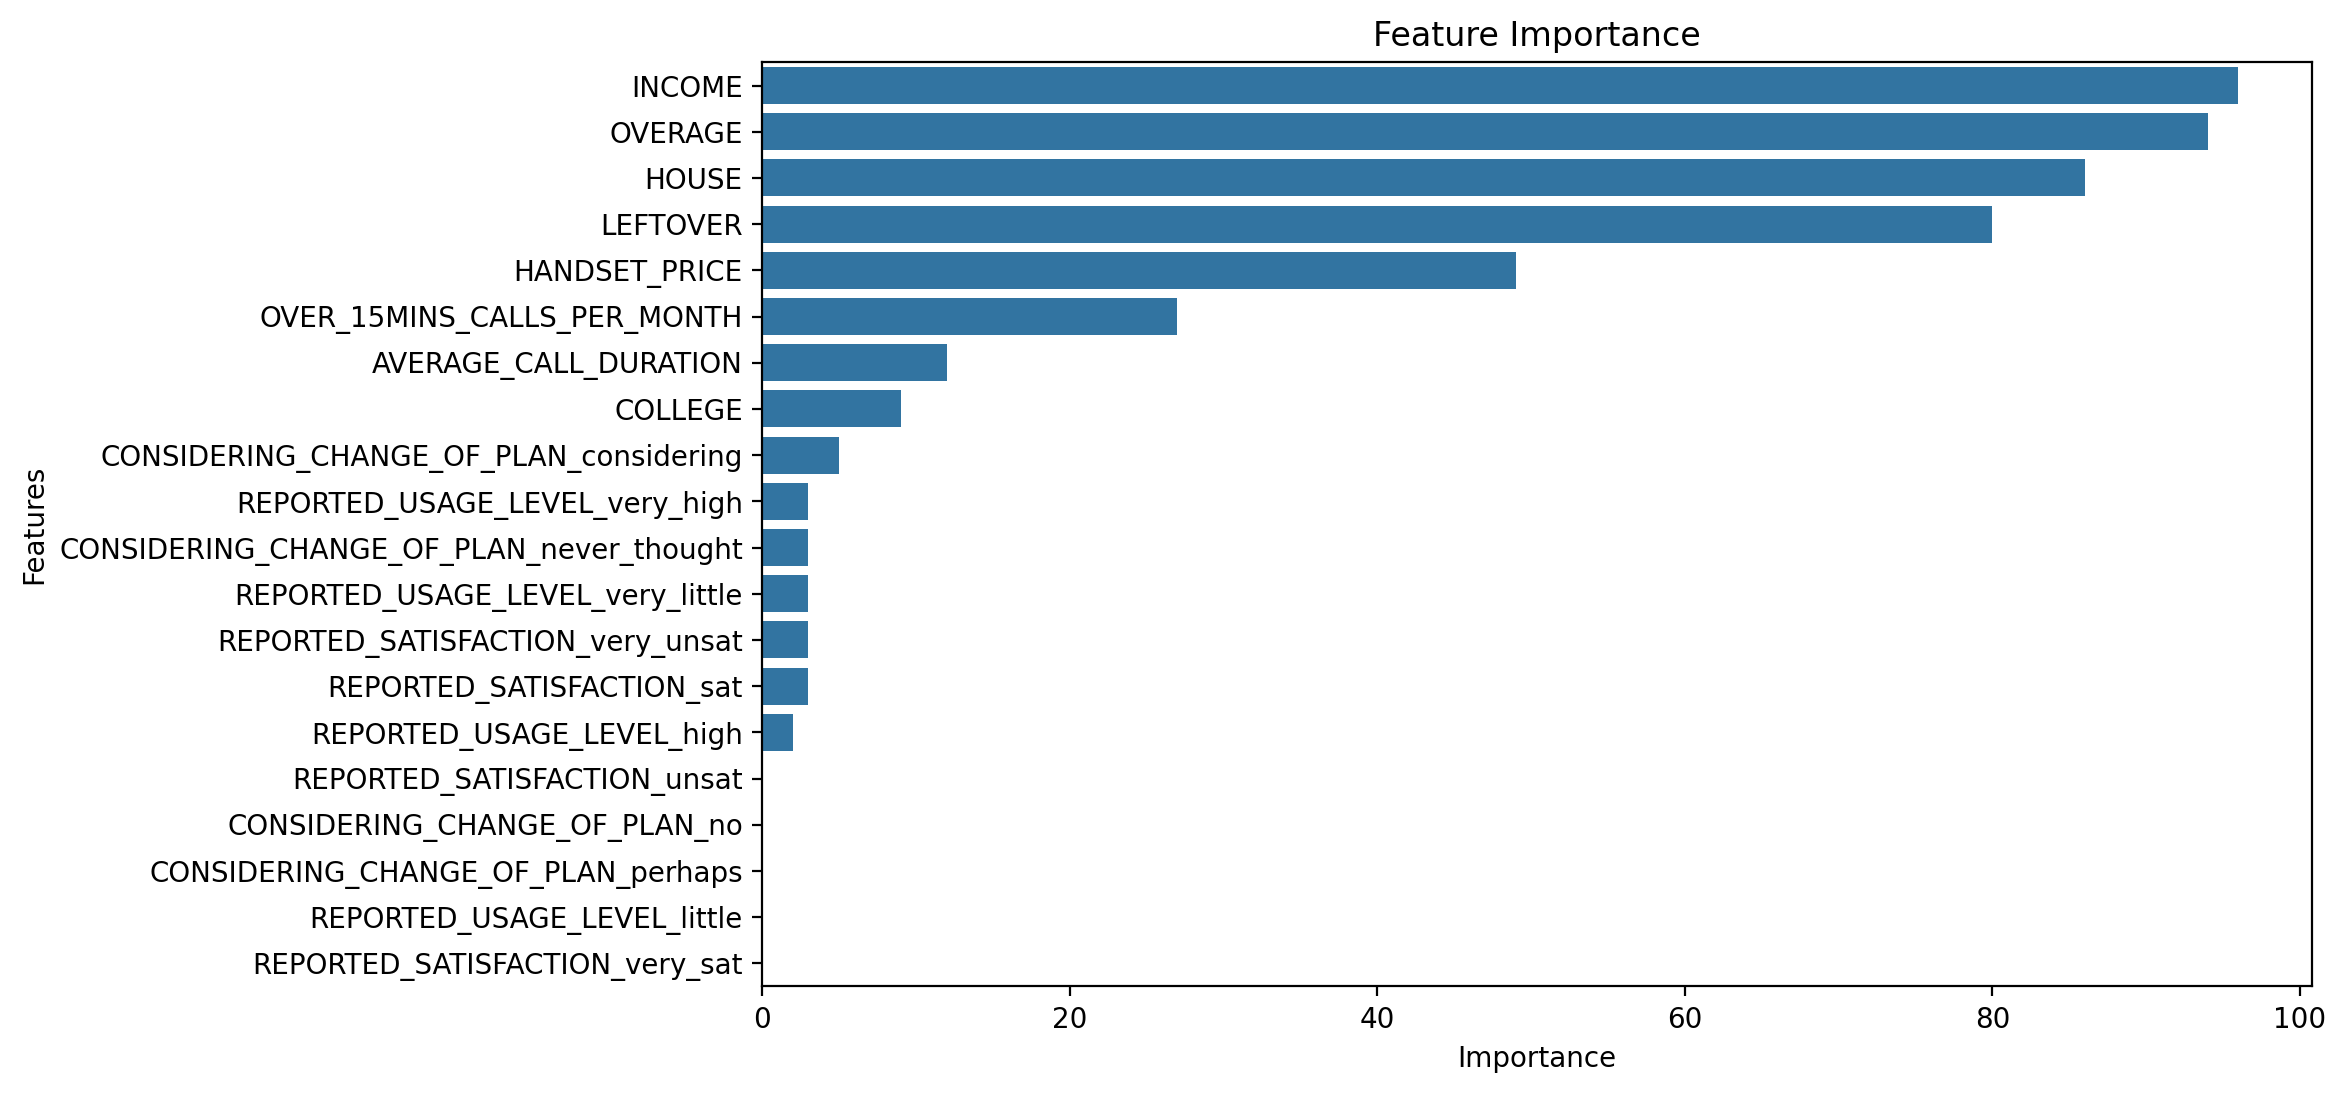

In [103]:
# 변수 중요도 시각화

# 학습된 최적 모델 가져오기
best_model = model_grid.best_estimator_

# 피처 중요도 추출
importances = best_model.feature_importances_

# 중요도를 데이터프레임으로 변환 (특성 이름과 중요도)
feature_names = x_train.columns if isinstance(x_train, pd.DataFrame) else [f"feature_{i}" for i in range(x_train.shape[1])]
feat_importances = pd.DataFrame({
    'Features': feature_names,
    'Importance': importances
})

# 중요도 기준으로 정렬
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=feat_importances)
plt.title('Feature Importance')
plt.show()


# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [105]:
# 예측하기
y_pred = best_model.predict(x_test)


Accuracy: 0.7004
F1 Score: 0.6998513805091399
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2537
           1       0.68      0.75      0.71      2463

    accuracy                           0.70      5000
   macro avg       0.70      0.70      0.70      5000
weighted avg       0.70      0.70      0.70      5000



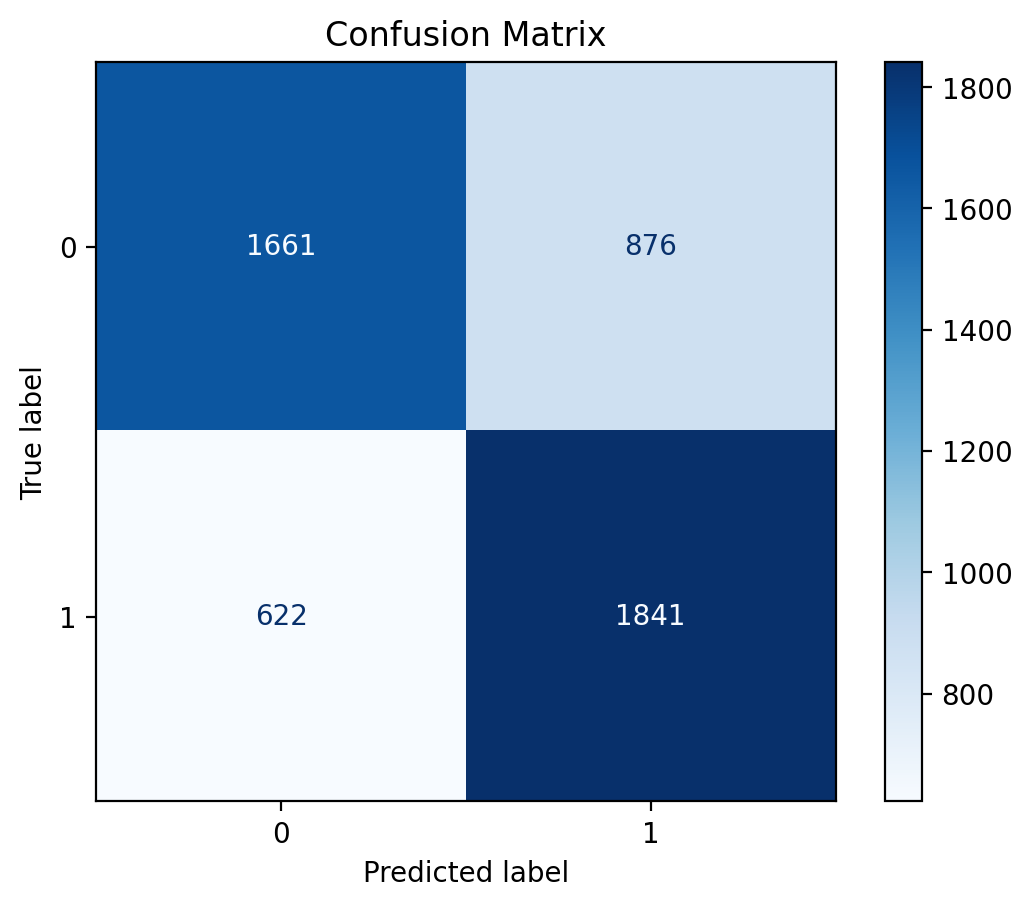

In [107]:
# 성능평가
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# 2. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 3. F1 스코어 평가
f1 = f1_score(y_test, y_pred, average='weighted')  # 다중 클래스일 경우 'weighted'로 평균
print("F1 Score:", f1)

# 4. 분류 리포트 출력 (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 5. 혼동 행렬
conf_matrix = confusion_matrix(y_test, y_pred)

# 6. 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
